In [44]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [2]:
def load_fashion_mnist():
    """
    Loads Fashion MNIST dataset.
    
    Adapted from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'    
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    with gzip.open(TRAIN_LABELS, 'rb') as tr_labels_file, gzip.open(TEST_LABELS, 'rb') as ts_labels_file:
        train_labels = np.frombuffer(tr_labels_file.read(), dtype=np.uint8, offset=8)
        test_labels = np.frombuffer(ts_labels_file.read(), dtype=np.uint8, offset=8)

    with gzip.open(TRAIN_IMAGES, 'rb') as tr_images_file, gzip.open(TEST_IMAGES, 'rb') as ts_images_file:
        train_images = np.frombuffer(tr_images_file.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
        test_images = np.frombuffer(ts_images_file.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_fashion_mnist()

In [3]:
y = train_labels
y.shape

(60000,)

In [4]:
# rescaling features using min-max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(train_images)
#train_scaled is X
test_scaled = scaler.fit_transform(test_images)
X.shape

(60000, 784)

In [5]:
small_y = y[:10000]
small_X = X[:10000,:]

In [6]:
print(small_X.shape)
print(small_y.shape)
#small_X and X have the same shape
#small_y and y have the same shape

(10000, 784)
(10000,)


In [81]:
# Create a nearest neighbor classifier
clf = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
clf

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3)

In [8]:
y_pred = cross_val_predict(clf, small_X, small_y, cv=5)

In [9]:
y_pred

array([9, 0, 3, ..., 0, 0, 2], dtype=uint8)

In [11]:
cm1 = confusion_matrix(small_y, y_pred, labels = [0, 1, 2, 3, 4,5,6,7,8,9])
cm1

array([[792,   2,  14,  29,   6,   0,  92,   0,   7,   0],
       [  9, 987,   9,  16,   1,   0,   5,   0,   0,   0],
       [ 27,   1, 754,   7, 117,   0, 104,   2,   4,   0],
       [ 77,  12,  18, 847,  40,   0,  23,   0,   2,   0],
       [ 14,   2, 167,  34, 664,   0,  91,   0,   2,   0],
       [  1,   0,   9,   2,   1, 780,   4, 119,   4,  69],
       [236,   3, 153,  22,  77,   0, 519,   0,  10,   1],
       [  0,   0,   0,   0,   0,   5,   0, 954,   0,  63],
       [  7,   1,  25,  10,   7,   1,  15,   8, 911,   5],
       [  1,   0,   1,   0,   0,   3,   1,  34,   0, 960]])

In [24]:
accuracy = accuracy_score(small_y, y_pred)
accuracy

0.8168

In [27]:
y_score = clf.predict_proba(small_X)
y_score

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ]])

In [34]:
lb = LabelBinarizer()
y_binarized = lb.fit_transform(small_y)
y_binarized

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
# Compute and plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lb.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [38]:
# Compute micro-averaged ROC curve and AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [39]:
# Compute macro-averaged ROC curve and AUC score
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

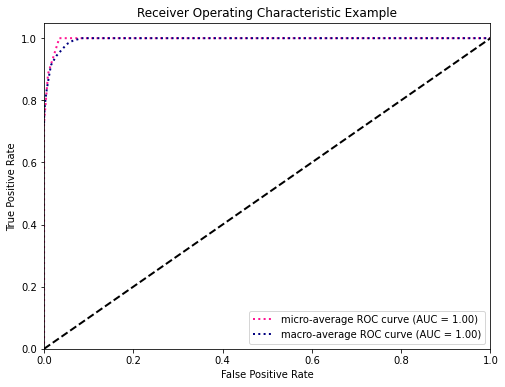

In [42]:
# Plot ROC curve for each class and the macro/micro averages
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

Feature Selection

In [43]:
# Compute the correlation coefficients between each feature and the target variable
corr_coef = []
for i in range(small_X.shape[1]):
    corr_coef.append(abs(np.corrcoef(X[:, i], y)[0, 1]))

In [73]:
# Select the top 10 features based on their correlation coefficients
selector = SelectKBest(score_func=f_classif, k=400)
selector.fit(small_X, small_y)
X_selected = selector.transform(small_X)
X_selected[0].shape
#small_X[0].shape

(400,)

In [74]:
# Print the indices of the selected features
selected_features = selector.get_support(indices=True)

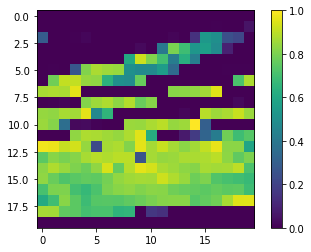

In [75]:
plt.figure()
plt.imshow(X_selected[0].reshape(20, 20))
plt.colorbar()
plt.grid(False)
plt.show()

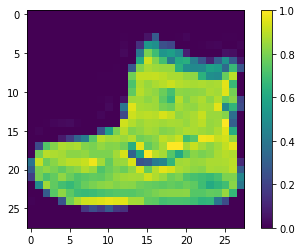

In [71]:
plt.figure()
plt.imshow(small_X[0].reshape(28, 28))
plt.colorbar()
plt.grid(False)
plt.show()

In [83]:
y_pred2 = cross_val_predict(clf, X_selected, small_y, cv=5)

In [84]:
cm2 = confusion_matrix(small_y, y_pred2, labels = [0, 1, 2, 3, 4,5,6,7,8,9])
cm2

array([[779,   2,  22,  38,   6,   0,  89,   0,   6,   0],
       [ 12, 989,   8,  12,   1,   0,   5,   0,   0,   0],
       [ 30,   1, 762,   8, 117,   0,  91,   1,   6,   0],
       [ 65,  14,  17, 853,  39,   0,  28,   0,   3,   0],
       [ 20,   1, 200,  39, 627,   0,  86,   0,   1,   0],
       [  2,   0,   1,   1,   3, 794,   1, 106,   8,  73],
       [240,   2, 163,  26,  71,   0, 503,   0,  15,   1],
       [  0,   0,   0,   0,   0,  10,   0, 952,   0,  60],
       [  6,   1,  29,   6,   2,   0,  12,   9, 922,   3],
       [  0,   0,   0,   0,   1,   7,   1,  33,   0, 958]])

In [85]:
accuracy2 = accuracy_score(small_y, y_pred2)
accuracy2

0.8139

In [88]:
clf.fit(X_selected,small_y)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3)

In [89]:
y_score2 = clf.predict_proba(X_selected)
y_score2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

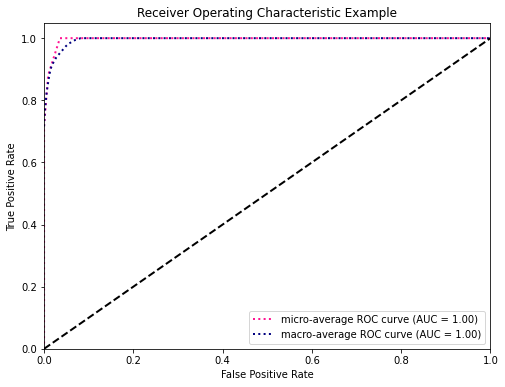

In [90]:
# Compute and plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lb.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-averaged ROC curve and AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-averaged ROC curve and AUC score
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class and the macro/micro averages
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()